Task 2: Develop Time Series Forecasting Models for All Datasets

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings("ignore")

tsla_data = pd.read_csv('../data/TSLA_data.csv', index_col='Date', parse_dates=True)
spy_data = pd.read_csv('../data/SPY_data.csv', index_col='Date', parse_dates=True)
bnd_data = pd.read_csv('../data/BND_data.csv', index_col='Date', parse_dates=True)


In [58]:
def preprocess_data(df):
    df = df[['Close']].copy()
    df.dropna(inplace=True)
    return df

tsla_data = preprocess_data(tsla_data)
spy_data = preprocess_data(spy_data)
bnd_data = preprocess_data(bnd_data)

In [59]:
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape


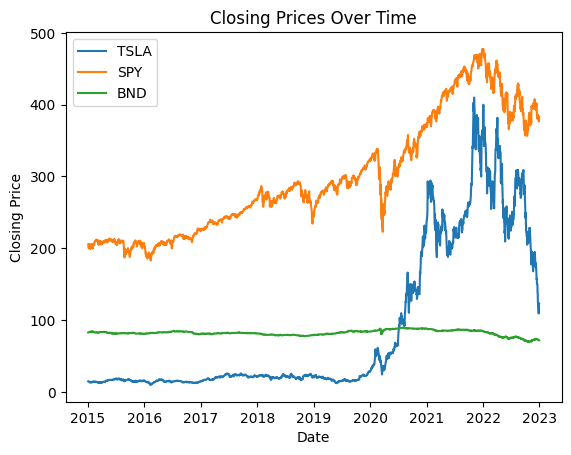

In [60]:
def plot_closing_prices(*dfs, labels):
    for df, label in zip(dfs, labels):
        plt.plot(df.index, df['Close'], label=label)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('Closing Prices Over Time')
    plt.show()

plot_closing_prices(tsla_data, spy_data, bnd_data, labels=['TSLA', 'SPY', 'BND'])


### Train ARIMA/SARIMA Models

In [61]:

def train_arima(data, order, steps=30):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast


ARIMA Model Training for BND, SPY, and TSLA

In [62]:
# BND ARIMA Forecast
forecast_bnd_arima = train_arima(bnd_data['Close'], order=(0,1,0))
mae_bnd_arima, rmse_bnd_arima, mape_bnd_arima = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_arima)

# SPY ARIMA Forecast
forecast_spy_arima = train_arima(spy_data['Close'], order=(3,1,1))
mae_spy_arima, rmse_spy_arima, mape_spy_arima = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_arima)

# TSLA ARIMA Forecast
forecast_tsla_arima = train_arima(tsla_data['Close'], order=(0,1,1))
mae_tsla_arima, rmse_tsla_arima, mape_tsla_arima = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_arima)


SARIMA Model Training for BND, SPY, and TSLA

In [63]:
def train_sarima(data, order, seasonal_order, steps=30):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast


In [64]:
# BND SARIMA Forecast
forecast_bnd_sarima = train_sarima(bnd_data['Close'], order=(0,1,0), seasonal_order=(2,1,0,5))
mae_bnd_sarima, rmse_bnd_sarima, mape_bnd_sarima = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_sarima)

# SPY SARIMA Forecast
forecast_spy_sarima = train_sarima(spy_data['Close'], order=(3,1,1), seasonal_order=(2,1,0,5))
mae_spy_sarima, rmse_spy_sarima, mape_spy_sarima = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_sarima)

# TSLA SARIMA Forecast
forecast_tsla_sarima = train_sarima(tsla_data['Close'], order=(0,1,1), seasonal_order=(0,0,0,0))
mae_tsla_sarima, rmse_tsla_sarima, mape_tsla_sarima = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_sarima)


LSTM Model Training for BND, SPY, and TSLA

In [65]:
def prepare_lstm_data(data, time_steps=60):
    scaled_data = (data - data.min()) / (data.max() - data.min())
    generator = TimeseriesGenerator(scaled_data.values, scaled_data.values, length=time_steps, batch_size=32)
    return generator, scaled_data

bnd_gen, bnd_scaled = prepare_lstm_data(bnd_data['Close'])
spy_gen, spy_scaled = prepare_lstm_data(spy_data['Close'])
tsla_gen, tsla_scaled = prepare_lstm_data(tsla_data['Close'])


In [66]:
def build_and_train_lstm(generator, epochs=10):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=epochs)
    return model

def forecast_with_lstm(model, scaled_data, steps=30):
    predictions = []
    batch = scaled_data[-60:].values.reshape((1, 60, 1))  

    for _ in range(steps):
        pred = model.predict(batch)[0]
        predictions.append(pred)
        batch = np.append(batch[:, 1:, :], [[pred]], axis=1)  

    return np.array(predictions).flatten()


def prepare_lstm_data(data, time_steps=60):

    scaled_data = (data - data.min()) / (data.max() - data.min())
    generator = TimeseriesGenerator(scaled_data.values, scaled_data.values, length=time_steps, batch_size=32)
    return generator, scaled_data


bnd_gen, bnd_scaled = prepare_lstm_data(bnd_data['Close'])
spy_gen, spy_scaled = prepare_lstm_data(spy_data['Close'])
tsla_gen, tsla_scaled = prepare_lstm_data(tsla_data['Close'])


model_bnd_lstm = build_and_train_lstm(bnd_gen, epochs=10)
model_spy_lstm = build_and_train_lstm(spy_gen, epochs=10)
model_tsla_lstm = build_and_train_lstm(tsla_gen, epochs=10)


forecast_bnd_lstm = forecast_with_lstm(model_bnd_lstm, bnd_scaled)
forecast_spy_lstm = forecast_with_lstm(model_spy_lstm, spy_scaled)
forecast_tsla_lstm = forecast_with_lstm(model_tsla_lstm, tsla_scaled)


mae_bnd_lstm, rmse_bnd_lstm, mape_bnd_lstm = evaluate_forecast(bnd_data['Close'][-30:], forecast_bnd_lstm)
mae_spy_lstm, rmse_spy_lstm, mape_spy_lstm = evaluate_forecast(spy_data['Close'][-30:], forecast_spy_lstm)
mae_tsla_lstm, rmse_tsla_lstm, mape_tsla_lstm = evaluate_forecast(tsla_data['Close'][-30:], forecast_tsla_lstm)

print("BND LSTM - MAE:", mae_bnd_lstm, "RMSE:", rmse_bnd_lstm, "MAPE:", mape_bnd_lstm)
print("SPY LSTM - MAE:", mae_spy_lstm, "RMSE:", rmse_spy_lstm, "MAPE:", mape_spy_lstm)
print("TSLA LSTM - MAE:", mae_tsla_lstm, "RMSE:", rmse_tsla_lstm, "MAPE:", mape_tsla_lstm)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0944
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0014
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.9599e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.7042e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.9883e-04
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0297
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.6002e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.1406e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - l

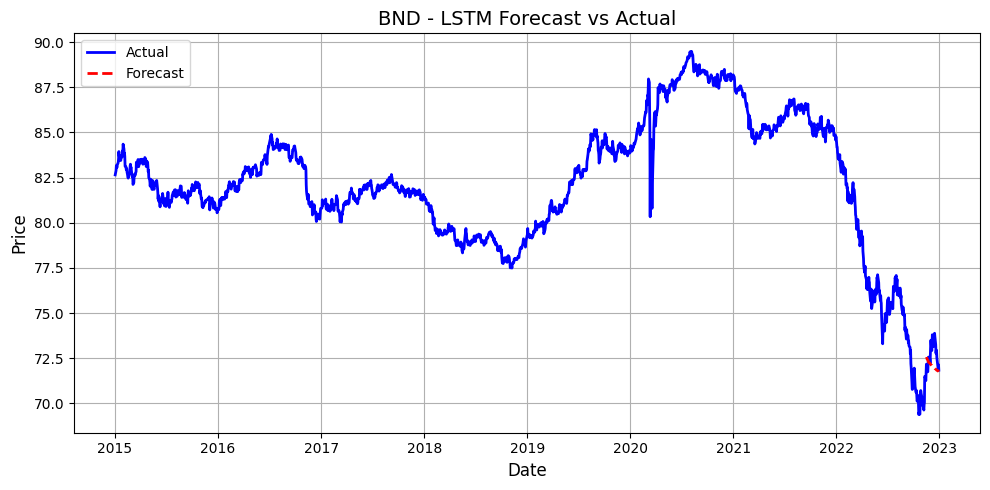

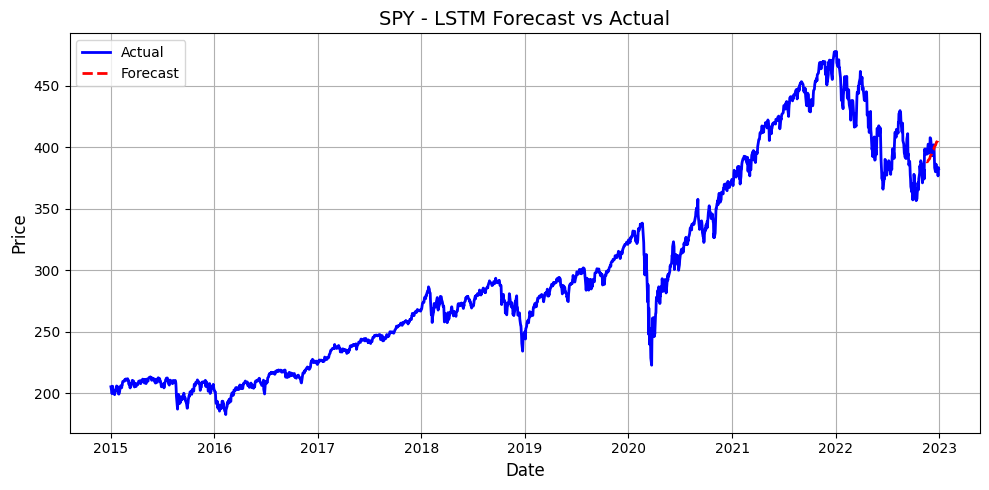

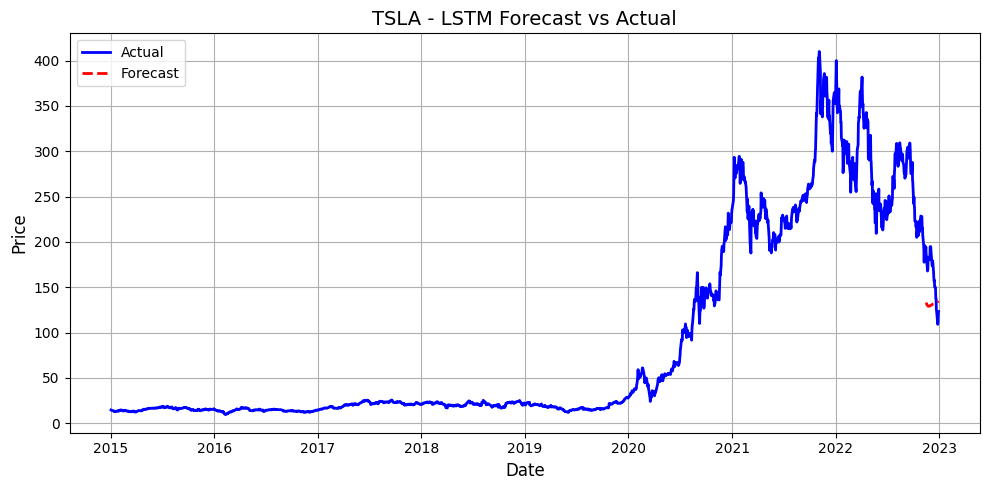

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast(data, forecast, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['Close'], label='Actual', color='blue', linewidth=2)
    plt.plot(data.index[-len(forecast):], forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title(f"{title} - LSTM Forecast vs Actual", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def invert_scaling(forecast, original_data):
    min_val = original_data.min()
    max_val = original_data.max()
    return forecast * (max_val - min_val) + min_val

forecast_bnd_lstm_inverted = invert_scaling(forecast_bnd_lstm, bnd_data['Close'])
forecast_spy_lstm_inverted = invert_scaling(forecast_spy_lstm, spy_data['Close'])
forecast_tsla_lstm_inverted = invert_scaling(forecast_tsla_lstm, tsla_data['Close'])

plot_forecast(bnd_data, forecast_bnd_lstm_inverted, "BND")
plot_forecast(spy_data, forecast_spy_lstm_inverted, "SPY")
plot_forecast(tsla_data, forecast_tsla_lstm_inverted, "TSLA")


### Task 4

In [68]:
df = pd.DataFrame({
    'TSLA': forecast_tsla_lstm_inverted,
    'BND': forecast_bnd_lstm_inverted,
    'SPY': forecast_spy_lstm_inverted
})

In [69]:
df_returns = df.pct_change().dropna()

In [70]:
annualized_returns = df_returns.mean() * 252  
cov_matrix = df_returns.cov() * 252 

In [71]:

def portfolio_performance(weights):
    portfolio_return = np.sum(weights * annualized_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

In [72]:
def negative_sharpe_ratio(weights):
    return -portfolio_performance(weights)[2]

In [73]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

bounds = tuple((0, 1) for _ in range(len(df.columns)))

initial_weights = np.array([1/3, 1/3, 1/3])

In [74]:
from scipy.optimize import minimize
optimized_result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_result.x

In [75]:
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(optimal_weights)

In [76]:
confidence_level = 5  

tsla_returns = df_returns['TSLA']
VaR_95_tsla = np.percentile(tsla_returns, confidence_level) * np.sqrt(252)

bnd_returns = df_returns['BND']
VaR_95_bnd = np.percentile(bnd_returns, confidence_level) * np.sqrt(252)

spy_returns = df_returns['SPY']
VaR_95_spy = np.percentile(spy_returns, confidence_level) * np.sqrt(252)

print("Value at Risk (95% Confidence):")
print("TSLA:", round(VaR_95_tsla, 4))
print("BND:", round(VaR_95_bnd, 4))
print("SPY:", round(VaR_95_spy, 4))

Value at Risk (95% Confidence):
TSLA: -0.1154
BND: -0.0145
SPY: 0.0108


In [77]:
df_weighted_returns = (df_returns * optimal_weights).sum(axis=1)
cumulative_returns = (1 + df_weighted_returns).cumprod() - 1

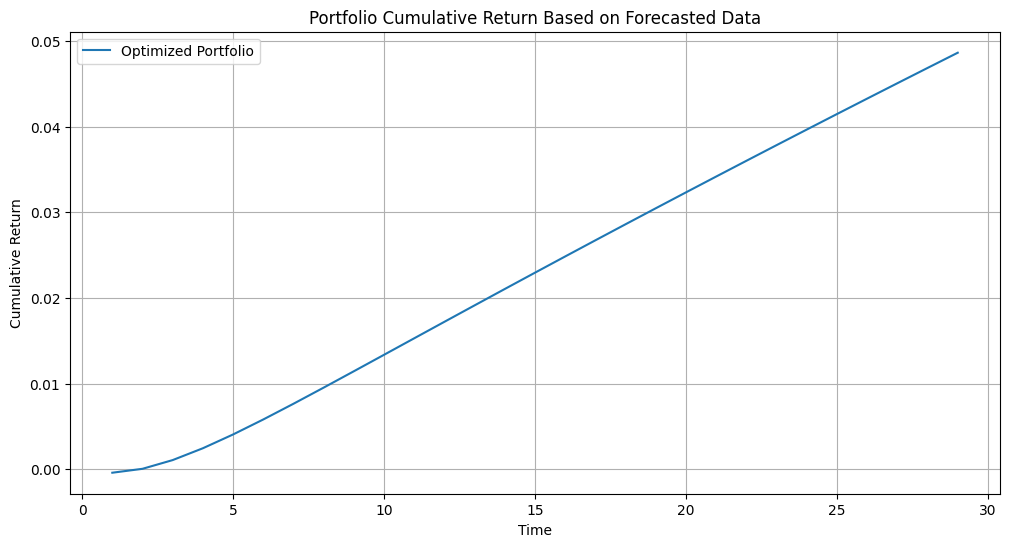

Optimal Portfolio Weights:
TSLA Weight: 0.0
BND Weight: 0.0
SPY Weight: 1.0

Portfolio Metrics:
Expected Annual Return: 0.4131
Annual Volatility (Risk): 0.0078
Sharpe Ratio: 52.6889
Value at Risk (95% Confidence) for TSLA: -0.2845


In [78]:
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title("Portfolio Cumulative Return Based on Forecasted Data")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

print("Optimal Portfolio Weights:")
print("TSLA Weight:", round(optimal_weights[0], 2))
print("BND Weight:", round(optimal_weights[1], 2))
print("SPY Weight:", round(optimal_weights[2], 2))

print("\nPortfolio Metrics:")
print("Expected Annual Return:", round(portfolio_return, 4))
print("Annual Volatility (Risk):", round(portfolio_volatility, 4))
print("Sharpe Ratio:", round(sharpe_ratio, 4))
print("Value at Risk (95% Confidence) for TSLA:", round(VaR_95, 4))